# Quick Success: Materials Search with Deep Learning

The goal of this quick success is simple, yet an actual implementation may take some time. We are going to write an Artificial Neural Network to predict the materials property. As a basic library for design the network we will use Torch which is the most convenient neural network environment when the work involves defining new layers.

The list of files in your current directory should be:

- This notebook
- quicksuccess_mining.ipynb
- quicksuccess_modules.ipynb
- quicksuccess_net.ipynb
- qucksuccess_train.ipynb

Main libraries:

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, time
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from IPython import display

In [27]:
# (re-)load modules
%run quicksuccess_mining.ipynb
%run quicksuccess_modules.ipynb
%run quicksuccess_net.ipynb
%run quicksuccess_train.ipynb

## Data mining

In [28]:
dataset = CIFData(root_dir = "superconductors",
                  max_num_nbr = 12,
                  radius=8,
                  dmin=0,
                  step=0.2)

In [29]:
orig_atom_fea_len = dataset[0][0][0].shape[-1]
nbr_fea_len = dataset[0][0][1].shape[-1]
print("Number of structures: {}".format(len(dataset)))
print("Number of features describing one atom: {}".format(orig_atom_fea_len))
print("Number of features describing neighbours: {}".format(nbr_fea_len))

Number of structures: 291
Number of features describing one atom: 92
Number of features describing neighbours: 41


In [30]:
indices = list(range(len(dataset)))
train_val_ratio = 0.7
train_sampler = SubsetRandomSampler(indices[:int(train_val_ratio*len(dataset))])
val_sampler = SubsetRandomSampler(indices[int(train_val_ratio*len(dataset)):])
train_loader = DataLoader(dataset, batch_size=64,
                          sampler=train_sampler,
                          collate_fn=collate_pool)
val_loader = DataLoader(dataset, batch_size=64,
                        sampler=val_sampler,
                        collate_fn=collate_pool)

## Creating model

In [31]:
model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0)
normalizer = Normalizer(collate_pool(dataset)[1])
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.1)
model.cuda()

CrystalGraphConvNet(
  (embedding): Linear(in_features=92, out_features=64, bias=True)
  (convs): ModuleList(
    (0): ConvLayer(
      (fc_full): Linear(in_features=169, out_features=128, bias=True)
      (sigmoid): Sigmoid()
      (softplus1): Softplus(beta=1, threshold=20)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (softplus2): Softplus(beta=1, threshold=20)
    )
    (1): ConvLayer(
      (fc_full): Linear(in_features=169, out_features=128, bias=True)
      (sigmoid): Sigmoid()
      (softplus1): Softplus(beta=1, threshold=20)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (softplus2): Softplus(beta=1, threshold=20)
    )
    (2): ConvLayer(
      (fc_full): Linear(in_features=169, out_featu

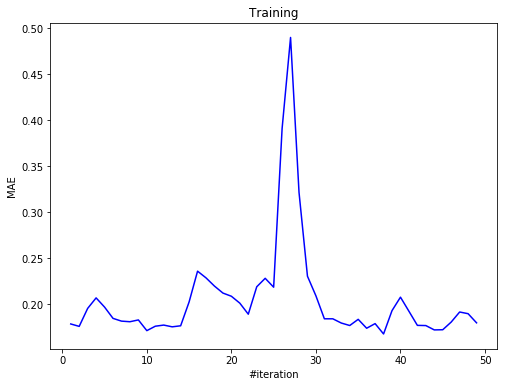

Epoch: 1	Loss: 0.294	MAE: 0.173
Epoch: 2	Loss: 0.309	MAE: 0.179
Epoch: 3	Loss: 0.319	MAE: 0.176
Epoch: 4	Loss: 0.389	MAE: 0.196
Epoch: 5	Loss: 0.471	MAE: 0.207
Epoch: 6	Loss: 0.409	MAE: 0.197
Epoch: 7	Loss: 0.344	MAE: 0.185
Epoch: 8	Loss: 0.316	MAE: 0.182
Epoch: 9	Loss: 0.338	MAE: 0.181
Epoch: 10	Loss: 0.339	MAE: 0.183
Epoch: 11	Loss: 0.280	MAE: 0.171
Epoch: 12	Loss: 0.299	MAE: 0.176
Epoch: 13	Loss: 0.303	MAE: 0.178
Epoch: 14	Loss: 0.292	MAE: 0.176
Epoch: 15	Loss: 0.301	MAE: 0.177
Epoch: 16	Loss: 0.397	MAE: 0.203
Epoch: 17	Loss: 0.641	MAE: 0.236
Epoch: 18	Loss: 0.552	MAE: 0.229
Epoch: 19	Loss: 0.477	MAE: 0.220
Epoch: 20	Loss: 0.463	MAE: 0.212
Epoch: 21	Loss: 0.447	MAE: 0.209
Epoch: 22	Loss: 0.397	MAE: 0.201
Epoch: 23	Loss: 0.331	MAE: 0.189
Epoch: 24	Loss: 0.628	MAE: 0.219
Epoch: 25	Loss: 0.692	MAE: 0.228
Epoch: 26	Loss: 0.465	MAE: 0.219
Epoch: 27	Loss: 1.851	MAE: 0.391
Epoch: 28	Loss: 2.453	MAE: 0.490
Epoch: 29	Loss: 1.157	MAE: 0.322
Epoch: 30	Loss: 0.589	MAE: 0.231
Epoch: 31	Loss: 0.4

In [36]:
best_mae_error = 1e10
epochs = 50
mae_history = []
text_history = []

for epoch in range(epochs):
        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch, normalizer)

        # evaluate on validation set
        loss_error, mae_error = validate(val_loader, model, criterion, normalizer)

        if mae_error != mae_error:
            print('Exit due to NaN')
            quit()

        #scheduler.step()
        
        #visualize
        display.clear_output(wait=True)
        if epoch != 0:
            mae_history.append(mae_error)
            plt.figure(figsize=(8, 6))

            plt.title("Training")
            plt.xlabel("#iteration")
            plt.ylabel("MAE")
            plt.plot(range(1, epoch + 1), mae_history, 'b')
            plt.show()
        text_history.append("Epoch: {}\tLoss: {:.3f}\tMAE: {:.3f}".format(epoch + 1, loss_error, mae_error))
        print("\n".join(text_history))

        # remember the best mae_eror and save checkpoint
        is_best = mae_error < best_mae_error
        best_mae_error = min(mae_error, best_mae_error)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_mae_error': best_mae_error,
            'optimizer': optimizer.state_dict(),
            'normalizer': normalizer.state_dict(),
        }, is_best,
        filename = 'checkpoint.pth.tar')

In [33]:
#plt.plot(np.arange(len(loss_save)), loss_save)
#plt.show()